# Navigation Task

In [1]:
import torch
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from model.kohonen_som import KohonenSOM
from model.manager_som import ManagerSOM
from model.manager_som_position import ManagerSOMPosition
from custom_env.navigation_task import NavigationTask
%matplotlib inline

path exception
path exception


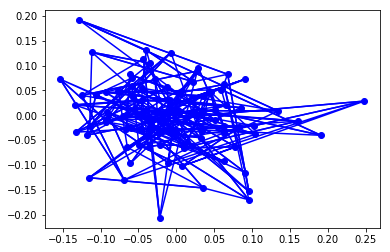

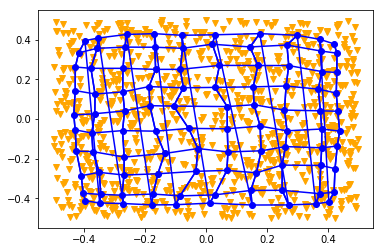

tensor([[ 0.4203,  0.3791],
        [ 0.4298,  0.3323],
        [ 0.4296,  0.2348],
        [ 0.4275,  0.1308],
        [ 0.4325,  0.0389],
        [ 0.4388, -0.0613],
        [ 0.4310, -0.1367],
        [ 0.4235, -0.2506],
        [ 0.4205, -0.3695],
        [ 0.4034, -0.4183],
        [ 0.3737,  0.4021],
        [ 0.3787,  0.3427],
        [ 0.3802,  0.2393],
        [ 0.3687,  0.1508],
        [ 0.3756,  0.0411],
        [ 0.3801, -0.0506],
        [ 0.3797, -0.1455],
        [ 0.3767, -0.2346],
        [ 0.3726, -0.3772],
        [ 0.3603, -0.4290],
        [ 0.2994,  0.4227],
        [ 0.2657,  0.3733],
        [ 0.2717,  0.2696],
        [ 0.2629,  0.1664],
        [ 0.2577,  0.0449],
        [ 0.2661, -0.0599],
        [ 0.2610, -0.1395],
        [ 0.2499, -0.2330],
        [ 0.2502, -0.3600],
        [ 0.2712, -0.4340],
        [ 0.1765,  0.4309],
        [ 0.1447,  0.3637],
        [ 0.1705,  0.2701],
        [ 0.1549,  0.1621],
        [ 0.1578,  0.0721],
        [ 0.1777, -0

In [2]:
x = torch.rand(1000, 2)-0.5
maxitr = 10**4*5
som = KohonenSOM(total_nodes=100, node_size=2, update_iterations=maxitr)
reshaped = som.w.reshape(10, 10, 2)
for v in range(10):
    plt.plot(reshaped[:, v, 0].numpy(), reshaped[:, v, 1].numpy(), marker='None', linestyle='-', color='blue')
    plt.plot(reshaped[v, :, 0].numpy(), reshaped[v, :, 1].numpy(), marker='None', linestyle='-', color='blue')
plt.plot(som.w[:, 0].numpy(), som.w[:, 1].numpy(), marker='o', color='blue')
plt.show()
for t in range(maxitr):
    a, c = som.update(x, t, 0)
    
plt.plot(x[:, 0].numpy(), x[:, 1].numpy(), marker='v', linestyle='None', color='orange')
reshaped = som.w.reshape(10, 10, 2)
for v in range(10):
    plt.plot(reshaped[:, v, 0].numpy(), reshaped[:, v, 1].numpy(), marker='None', linestyle='-', color='blue')
    plt.plot(reshaped[v, :, 0].numpy(), reshaped[v, :, 1].numpy(), marker='None', linestyle='-', color='blue')
plt.plot(som.w[:, 0].numpy(), som.w[:, 1].numpy(), marker='o', color='blue')
plt.show()
som.w

## Modified Manager Self Organizing Map

In [3]:
class ModifiedManagerSOM (ManagerSOM):
    """
    Removed clustering of neighboring neurons
    
    Set Bellman operator 
        from Q(s, a) <- r(s, a) + max_a Q(s', a) 
        to Q(s, a) <- r(s, a) + max_a Q(s, a)
    
    """
    
    def __init__(self, total_nodes = None, state_som = None, worker_som = None, update_iterations = None):
        super().__init__(
            total_nodes = total_nodes, 
            state_som = state_som, 
            worker_som = worker_som, 
            update_iterations = update_iterations)
        
    def action_q_learning(self,
                        current_state_index = None,
                        action_index = None,
                        next_state_index = None,
                        reward = 0,
                        t = None,
                        htype = 0,
                        lr = 0.9,
                        gamma = 0.9):
        current_state_space = torch.zeros(self.state_som.total_nodes)
        current_state_space[current_state_index] = 1

        winner_c = self.select_winner(current_state_space)

        # update q-value using new reward and largest est. prob of action
        self.w[winner_c][self.state_som.total_nodes + action_index] += lr * (
            reward
            + gamma * self.get_value(current_state_space)
            - self.w[winner_c][self.state_som.total_nodes + action_index]
            )

/Users/johnlime/Documents/MultipleApps/h_som/model/manager_som.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return torch.max(self.w[self.select_winner(x)][-self.worker_som.total_nodes:])[0]


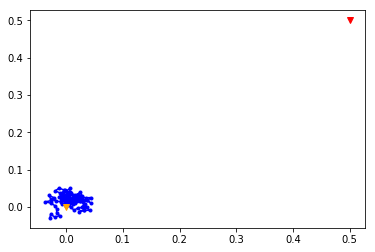

0 tensor(-4.6742)


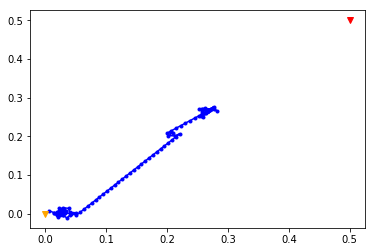

99 tensor(-4.6730)


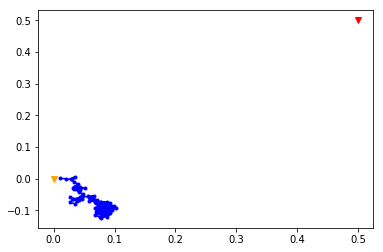

198 tensor(-4.9124)


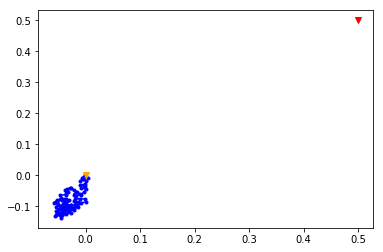

297 tensor(-5.4176)


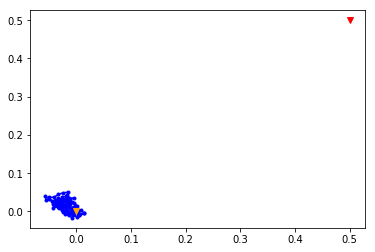

396 tensor(-5.0299)


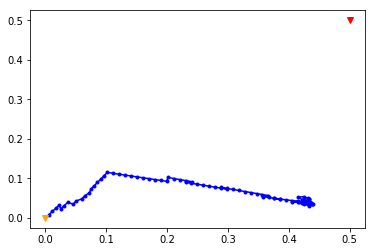

495 tensor(-4.0207)


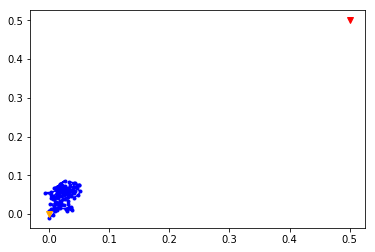

594 tensor(-4.7235)


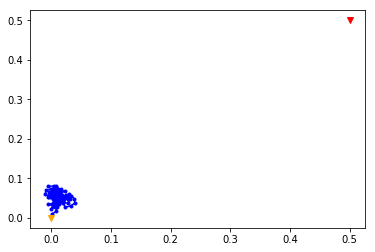

693 tensor(-4.5240)


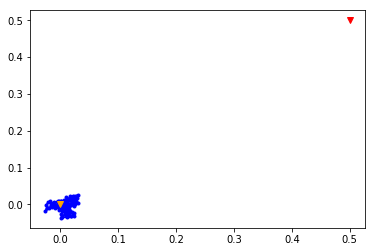

792 tensor(-5.0420)


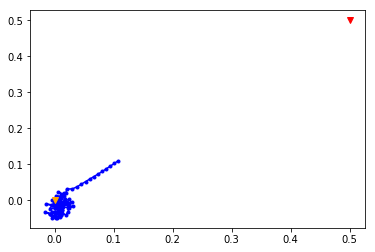

891 tensor(-4.9373)


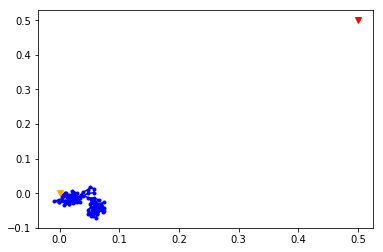

990 tensor(-4.9127)


In [15]:
manager_maxitr = 10 ** 3
maxtime = 100
epsilon = 0.2
torch.manual_seed(0)
random.seed(0)

manager_som = ModifiedManagerSOM(total_nodes=100, state_som = som, worker_som=som, update_iterations=manager_maxitr)
task = NavigationTask()

for epoch in range(manager_maxitr):
    # for visualization
    total_return = 0
    state_trajectory = []
    obs = task.state()
    
    for t in range(maxtime):
        obs = task.state()
        state_vector = torch.zeros(som.total_nodes)
        state_vector[som.select_winner(obs)] = 1
        
        # epsilon greedy
        if random.random() > epsilon:
            action_index = manager_som.get_action(state_vector) # deterministic

        else:
            action_index = random.randrange(som.total_nodes)
        
        # step forward
        reward, next_obs = task.step(som.w[action_index])
        
        # online training
        manager_som.action_q_learning(
            current_state_index = som.select_winner(obs),
            action_index = action_index,
            reward = reward,
            t = epoch)
        
        obs = next_obs
        state_trajectory.append(np.array(obs))
        total_return += (0.9 ** t) * reward
        
    if epoch % 99 == 0:
        plt.plot(np.array(state_trajectory)[:, 0], np.array(state_trajectory)[:, 1], marker='.', linestyle='-', color='blue')
        plt.plot(0.0, 0.0, marker='v', linestyle='None', color='orange')
        plt.plot(np.array(task.goal)[0], np.array(task.goal)[1], marker='v', linestyle='None', color='red')
        plt.show()
        print(epoch, total_return)
    
    task.reset()

trajectories.append(torch.cat((
    current_position, 
    action_index.reshape(1).float(),
    reward_value.reshape(1).float(), 
    next_position)))

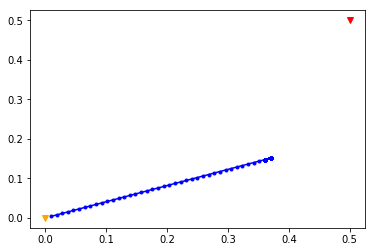

tensor(-3.8909)


In [16]:
# for visualization
total_return = 0
state_trajectory = []

for t in range(maxtime): 
    obs = task.state()
    state_vector = torch.zeros(som.total_nodes)
    state_vector[som.select_winner(obs)] = 1
    action_index = manager_som.get_action(state_vector) # deterministic

    # step forward
    reward, next_obs = task.step(som.w[action_index])

    obs = next_obs
    state_trajectory.append(np.array(obs))
    total_return += (0.9 ** t) * reward

plt.plot(np.array(state_trajectory)[:, 0], np.array(state_trajectory)[:, 1], marker='.', linestyle='-', color='blue')
plt.plot(0.0, 0.0, marker='v', linestyle='None', color='orange')
plt.plot(np.array(task.goal)[0], np.array(task.goal)[1], marker='v', linestyle='None', color='red')
plt.show()
print(total_return)

task.reset()

## Modfied Position-based Manager SOM

In [17]:
class ModifiedManagerSOMPosition (ManagerSOMPosition):
    """
    Removed clustering of neighboring neurons
    
    Set Bellman operator 
        from Q(s, a) <- r(s, a) + max_a Q(s', a) 
        to Q(s, a) <- r(s, a) + max_a Q(s, a)
    
    """
    
    def __init__(self, total_nodes = None, state_som = None, worker_som = None, update_iterations = None):
        super().__init__(
            total_nodes = total_nodes, 
            state_som = state_som, 
            worker_som = worker_som, 
            update_iterations = update_iterations)
        
    def action_q_learning(self,
                        current_state_position = None,
                        action_index = None,
                        next_state_position = None,
                        reward = 0,
                        t = None,
                        htype = 0,
                        lr = 0.9,
                        gamma = 0.9):
        winner_c = self.select_winner(current_state_position)

        # update q-value using new reward and largest est. prob of action
        self.w[winner_c][2 + action_index] += lr * (
            reward
            + gamma * self.get_softmax(current_state_position)
            - self.w[winner_c][2 + action_index]
            )

/Users/johnlime/Documents/MultipleApps/h_som/model/manager_som_position.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ][-self.worker_som.total_nodes:]))[0]
/Users/johnlime/Documents/MultipleApps/h_som/model/manager_som_position.py:44: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  ][-self.worker_som.total_nodes:]))[0]


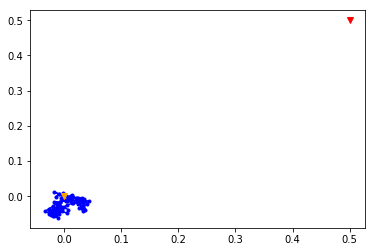

0 tensor(-4.9338)


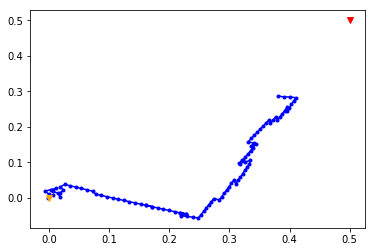

99 tensor(-4.5849)


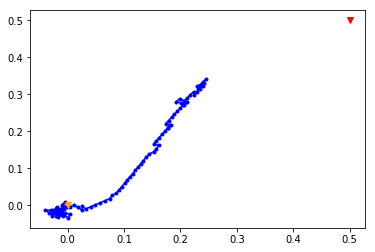

198 tensor(-5.2291)


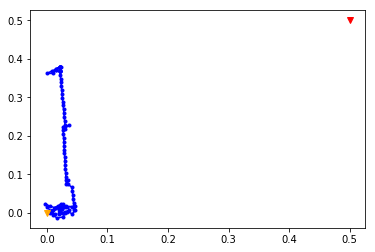

297 tensor(-4.7199)


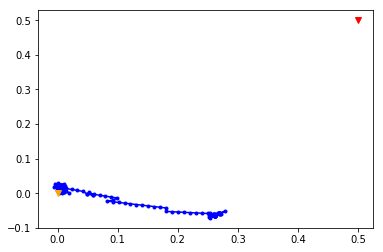

396 tensor(-4.7878)


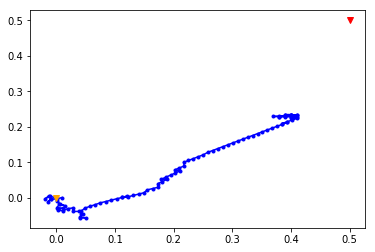

495 tensor(-5.0338)


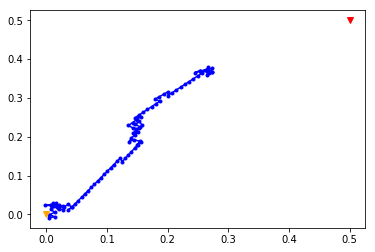

594 tensor(-4.6435)


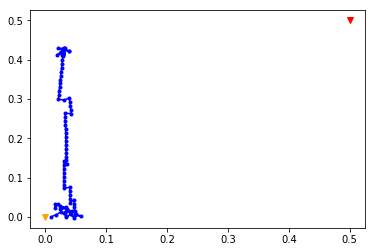

693 tensor(-4.5376)


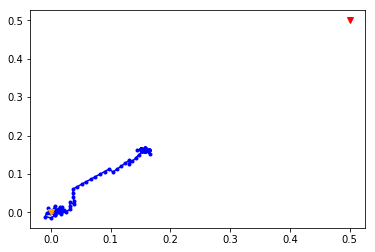

792 tensor(-4.7886)


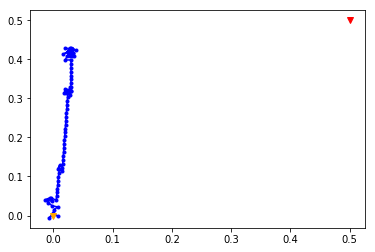

891 tensor(-4.6268)


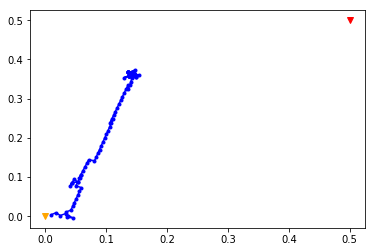

990 tensor(-4.3094)


In [18]:
manager_som_pos = ModifiedManagerSOMPosition(total_nodes=100, state_som = som, worker_som=som, update_iterations=manager_maxitr)

for epoch in range(manager_maxitr):
    # for visualization
    total_return = 0
    state_trajectory = []
    obs = task.state()
    
    for t in range(maxtime):
        obs = task.state()
        
        # epsilon greedy
        if random.random() > epsilon:
            action_index = manager_som_pos.get_action(som.location[som.select_winner(obs)]) # deterministic

        else:
            action_index = random.randrange(som.total_nodes)
        
        # step forward
        reward, next_obs = task.step(som.w[action_index])
        
        # online training
        manager_som_pos.action_q_learning(
            current_state_position = som.location[som.select_winner(obs)],
            action_index = action_index,
            reward = reward,
            t = epoch)
        
        obs = next_obs
        state_trajectory.append(np.array(obs))
        total_return += (0.9 ** t) * reward
        
    if epoch % 99 == 0:
        plt.plot(np.array(state_trajectory)[:, 0], np.array(state_trajectory)[:, 1], marker='.', linestyle='-', color='blue')
        plt.plot(0.0, 0.0, marker='v', linestyle='None', color='orange')
        plt.plot(np.array(task.goal)[0], np.array(task.goal)[1], marker='v', linestyle='None', color='red')
        plt.show()
        print(epoch, total_return)
    
    task.reset()

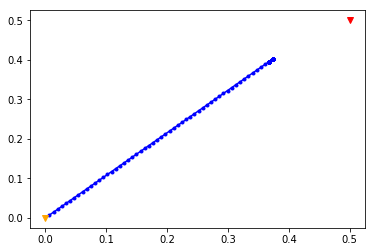

tensor(-3.7772)


In [19]:
# for visualization
total_return = 0
state_trajectory = []

for t in range(maxtime): 
    obs = task.state()
    action_index = manager_som_pos.get_action(som.location[som.select_winner(obs)]) # deterministic

    # step forward
    reward, next_obs = task.step(som.w[action_index])

    obs = next_obs
    state_trajectory.append(np.array(obs))
    total_return += (0.9 ** t) * reward

plt.plot(np.array(state_trajectory)[:, 0], np.array(state_trajectory)[:, 1], marker='.', linestyle='-', color='blue')
plt.plot(0.0, 0.0, marker='v', linestyle='None', color='orange')
plt.plot(np.array(task.goal)[0], np.array(task.goal)[1], marker='v', linestyle='None', color='red')
plt.show()
print(total_return)

task.reset()